<a href="https://colab.research.google.com/github/umbertodicanito/Stochastic-Training-of-Graph-Convolutional-Networks-with-Variance-Reduction/blob/master/PubMed_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline



Graph Convolutional Network
====================================

**Author:** `Qi Huang <https://github.com/HQ01>`_, `Minjie Wang  <https://jermainewang.github.io/>`_,
Yu Gai, Quan Gan, Zheng Zhang

This is a gentle introduction of using DGL to implement Graph Convolutional
Networks (Kipf & Welling et al., `Semi-Supervised Classification with Graph
Convolutional Networks <https://arxiv.org/pdf/1609.02907.pdf>`_). We build upon
the :doc:`earlier tutorial <../../basics/3_pagerank>` on DGLGraph and demonstrate
how DGL combines graph with deep neural network and learn structural representations.


Model Overview
------------------------------------------
GCN from the perspective of message passing
```````````````````````````````````````````````
We describe a layer of graph convolutional neural network from a message
passing perspective; the math can be found `here <math_>`_.
It boils down to the following step, for each node $u$:

1) Aggregate neighbors' representations $h_{v}$ to produce an
intermediate representation $\hat{h}_u$.  2) Transform the aggregated
representation $\hat{h}_{u}$ with a linear projection followed by a
non-linearity: $h_{u} = f(W_{u} \hat{h}_u)$.

We will implement step 1 with DGL message passing, and step 2 with the
``apply_nodes`` method, whose node UDF will be a PyTorch ``nn.Module``.

GCN implementation with DGL
``````````````````````````````````````````
We first define the message and reduce function as usual.  Since the
aggregation on a node $u$ only involves summing over the neighbors'
representations $h_v$, we can simply use builtin functions:



In [0]:
!pip install dgl

In [0]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from google.colab import files
import warnings
import matplotlib.pyplot as plt

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

We then define the node UDF for ``apply_nodes``, which is a fully-connected layer:



In [0]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        #M=(P'_l*(H_l-H'_l)+P*H'_l)
        #H_l = node.data['h']
        #P' dato da alg. 1
        #H' dato da alg. 1
        #P ricavata inizialmente da noi
        #z = self.linear(M)
        z = self.linear(node.data['h'])
        h = self.activation(z)
        return {'h' : h}

We then proceed to define the GCN module. A GCN layer essentially performs
message passing on all the nodes then applies the `NodeApplyModule`. Note
that we omitted the dropout in the paper for simplicity.



In [0]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

The forward function is essentially the same as any other commonly seen NNs
model in PyTorch.  We can initialize GCN like any ``nn.Module``. For example,
let's define a simple neural network consisting of two GCN layers. Suppose we
are training the classifier for the cora dataset (the input feature size is
1433 and the number of classes is 7).



We load the cora dataset using DGL's built-in data module.



We then train the network as follows:




GCN in one formula
------------------
Mathematically, the GCN model follows this formula:

$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$

Here, $H^{(l)}$ denotes the $l^{th}$ layer in the network,
$\sigma$ is the non-linearity, and $W$ is the weight matrix for
this layer. $D$ and $A$, as commonly seen, represent degree
matrix and adjacency matrix, respectively. The ~ is a renormalization trick
in which we add a self-connection to each node of the graph, and build the
corresponding degree and adjacency matrix.  The shape of the input
$H^{(0)}$ is $N \times D$, where $N$ is the number of nodes
and $D$ is the number of input features. We can chain up multiple
layers as such to produce a node-level representation output with shape
$(N \times F)$, where $F$ is the dimension of the output node
feature vector.

The equation can be efficiently implemented using sparse matrix
multiplication kernels (such as Kipf's
`pygcn <https://github.com/tkipf/pygcn>`_ code). The above DGL implementation
in fact has already used this trick due to the use of builtin functions. To
understand what is under the hood, please read our tutorial on :doc:`PageRank <../../basics/3_pagerank>`.



#What is been done?

#Let's try it with PubMed

In [0]:
from dgl.data import citation_graph as citegrh
import networkx as nx
def load_pubmed_data():
    data = citegrh.load_pubmed()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    mask = th.ByteTensor(data.train_mask)
    g = data.graph
    print(g)
    # add self loop
    g.remove_edges_from(nx.selfloop_edges(g))
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, mask

load_pubmed_data()

Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000



(DGLGraph(num_nodes=19717, num_edges=108365,
          ndata_schemes={}
          edata_schemes={}),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0554, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0114, 0.0047,  ..., 0.0000, 0.0000, 0.0000],
         [0.0531, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0145, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([1, 1, 0,  ..., 2, 0, 2]),
 tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8))

In [0]:
class NetPubMed(nn.Module):
    def __init__(self):
        super(NetPubMed, self).__init__()
        self.gcn1 = GCN(500, 30, F.relu)
        self.gcn2 = GCN(30, 3, F.relu)
    
    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        return x
netpm = NetPubMed()
print(netpm)

NetPubMed(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=500, out_features=30, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=30, out_features=3, bias=True)
    )
  )
)


In [0]:
import time
import numpy as np
warnings.filterwarnings('ignore')

#points for graph
pointsPubMed = []
pointsLossPubMed = []

#get data
g, features, labels, mask = load_pubmed_data()
print(g)

#get how many 1 are in 'mask'
maskLen = 0
for m in mask:
  if m.item() == 1:
    maskLen = maskLen + 1

#?
optimizer = th.optim.Adam(netpm.parameters(), lr=2e-2)
dur = []
for epoch in range(200):
    if epoch >=3:
        t0 = time.time()

    #calling 'net(...)' it asks to the GCN to compute the forward     
    logits = netpm(g, features)
    logp = F.log_softmax(logits, 1)

    #compute loss like the negative log likelihood loss
    loss = F.nll_loss(logp[mask], labels[mask])
    
    
    #Since the backward() function accumulates gradients, and you 
    #don’t want to mix up gradients between minibatches, you have 
    #to zero them out at the start of a new minibatch. This is 
    #exactly like how a general (additive) accumulator variable is 
    #initialized to 0 in code.
    optimizer.zero_grad()

    #update network weights by loss
    loss.backward()

    #update optimizer's values after backward
    optimizer.step()

    #computing accuracy
    i = 0
    matched = 0
    while i < 19717:
      if mask[i] == 0:
        #getting index of the maximum
        j = 0
        max = None
        jMax = 0
        for a in logp[i]:
          if max==None:
            max = a.item()
            jMax = j
          elif max < a.item():
            max = a.item()
            jMax = j
          j = j + 1
        if jMax == labels[i]:
          matched = matched + 1
      i = i + 1
    acc = matched/(19717-maskLen)*100

    pointsPubMed.append(acc)
    pointsLossPubMed.append(loss)
    if epoch >=3:
        dur.append(time.time() - t0)
    
    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy: {:.6f}".format(
            epoch, loss.item(), np.mean(dur), acc))

Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000

DGLGraph(num_nodes=19717, num_edges=108365,
         ndata_schemes={}
         edata_schemes={})
Epoch 00000 | Loss 1.1014 | Time(s) nan | Accuracy: 35.498804
Epoch 00001 | Loss 0.9555 | Time(s) nan | Accuracy: 50.358651
Epoch 00002 | Loss 0.8423 | Time(s) nan | Accuracy: 53.970596
Epoch 00003 | Loss 0.7822 | Time(s) 1.4832 | Accuracy: 54.077428
Epoch 00004 | Loss 0.7094 | Time(s) 1.4761 | Accuracy: 52.627563
Epoch 00005 | Loss 0.6610 | Time(s) 1.4853 | Accuracy: 52.332502
Epoch 00006 | Loss 0.6080 | Time(s) 1.4840 | Accuracy: 55.919011
Epoch 00007 | Loss 0.5429 | Time(s) 1.4856 | Accuracy: 58.228621
Epoch 00008 | Loss 0.4838 | Time(s) 1.4877 | Accuracy: 62.827491
Epoch 00009 | Loss 0.4106 | Time(s) 1.4936 | Accuracy: 70.203999
Epoch 00010 | Loss 0.3376 | Time(s) 1.5025 | Accuracy: 75.998372
Epoch 00011

#On graphic

In [0]:
#maxAccCora = np.argmax(pointsCora)
maxAccPubMed = np.argmax(pointsPubMed)

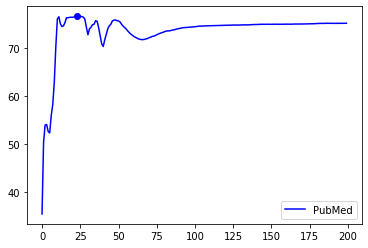

In [0]:
axisX = range(200)

#plt.plot(axisX, pointsCora, color='orange', label='Cora')
plt.plot(axisX, pointsPubMed, color='blue', label='PubMed')
#plt.plot([maxAccCora], pointsCora[maxAccCora], marker='o', color='orange')
plt.plot([maxAccPubMed], pointsPubMed[maxAccPubMed], marker='o', color='blue')
plt.legend()
plt.show()

In [0]:
#print("Max accuracy Cora at {:03d} epochs with value {:05f}"
#  .format(maxAccCora, pointsCora[maxAccCora]))
print("Max accuracy PubMed at {:03d} epochs with value {:05f}"
  .format(maxAccPubMed, pointsPubMed[maxAccPubMed]))

Max accuracy PubMed at 023 epochs with value 76.583405


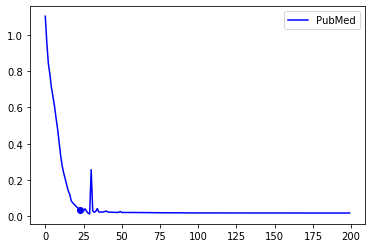

In [0]:
#plt.plot(axisX, pointsLossCora, color='orange', label='Cora')
plt.plot(axisX, pointsLossPubMed, color='blue', label='PubMed')
#plt.plot([maxAccCora], pointsLossCora[maxAccCora].item(), marker='o', color='orange')
plt.plot([maxAccPubMed], pointsLossPubMed[maxAccPubMed].item(), marker='o',color='blue')
plt.legend()
plt.show()

In [0]:
#print("For Cora, at epoch {:03d}, loss was {:05f}"
#  .format(maxAccCora, pointsLossCora[maxAccCora]))
print("For PubMed, at epoch {:03d}, loss was {:05f}"
  .format(maxAccPubMed, pointsLossPubMed[maxAccPubMed]))

For PubMed, at epoch 023, loss was 0.037344


#Implementing algorithm 1

In [0]:
#TODO: rivedere algoritmo#

#minibatch = np.array of nodes
#level = integer representing the level until we want to compute
#n = number of neighbors per node in the layer

#returning: the receptive fields and the propagation matrices
def algOne(minibatch, level, n):
  rL = minibatch
  l = level
  #in the paper n = 2
  n=2

  receptiveField = dict()
  propagationMatrix = dict()

  receptiveField[l] = rL

  #first for-loop
  while l > 0:
    field = []
    matrixP = np.zeros((2708,2708))
    #second for-loop
    for node in receptiveField[l]:
      if node not in field:
        field.append(node)
      matrixP[node][node] = matrixP[node][node] + P[node][node] * D[node][0] / n
      #collecting n random neighbor
      subset = []
      if len(neighborForNode[node]) <= n:
        subset = neighborForNode[node]
      else:
        subset = random.sample(neighborForNode[node], k=n)
      #last for-loop
      for neighbor in subset:
        if neighbor not in field:
          field.append(neighbor)
        matrixP[node][neighbor] = matrixP[node][neighbor] + P[node][neighbor] * D[node][0] / n
    
    #updating level
    l = l - 1
    receptiveField[l] = field
    propagationMatrix[l] = matrixP
  
  return [receptiveField, propagationMatrix]

#Se sta cosa funziona voglio il Nobel.